# When to Kick for Goal (Pro14) ?

## The Question 

When winning a pentaly are you better off:

* kicking for posts, 
* going for the courner, 
* taking a quick tap or, 
* asking for a scrum? 

And, how does the answer change depending on the location of the penalty?  

In this notebook we will review 171 Pro14 matches from between 2018/2019 and 2019/2020 seasons to find the answer. 

**NOTE** This notebook should be general enough that you can re-run it any set up games to update the answer or look into a specific team

## The Answer

For those who are not into Maths and Python and just want the answer it is:

* The expected points from an attacking Lineout within 10 of the try line is greater than 3 points,


* From every goal kickable penalty location a kicker should be able to just as easierly find touch to with in 10,


* If you have a couple min left in the game and are less than 3 points behind take the points,


* A tap penalty under the posts from 5 is better than a goal kick but worse than line out or scrum. There will be a skew in the data as a players only do this when they are 99% sure they are going to score,


* Scrums with in 10 and center field are a better decision than a kick for goal but you are worse than setting up a Lineout

# Data Prep

In [57]:
# imports 
import os
import pyrugga as pgr

import matplotlib.pyplot as plt
#import seaborn as sns

import pandas as pd
#import modin.pandas as pd

import numpy as np

import scipy as sp

import seaborn as sns

#local file with some utility code
import data_prep as dp

plt.style.context('tableau-colorblind10')

In [40]:
# scan folder with xml's and load files into a array of dataframes
FILES_LOC = '../../datalake/Rugby/pro14/'
matches = dp.get_matches(FILES_LOC)

Number of Matches : 172
First game : 2018-02-11 00:00:00
Last game : 2020-06-03 00:00:00


In [46]:
df = dp.flatten_data(matches)
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
fixture_code,419134,419134,419134,419134,419134,419134,419134,419134,419134,419134
team_name,Dragons,Scarlets,Scarlets,Dragons,Scarlets,Dragons,Dragons,Scarlets,Dragons,Scarlets
start_event,50m Restart,Kick Return,50m Restart,Lineout,Start Set 22m Restart Retained,Turnover Won,Scrum,50m Restart,Kick Return,Kick Return
end_event,End Set Kick In Play,End Turnover (Scrum),End Kick Out Of Play,End Turnover (Scrum),End Turnover,End Scrum,End Pen Con,End Set Kick In Play,End Set Kick In Play,End Turnover
points,0,3,0,0,0,0,-3,0,0,0
length,24,43,8,24,33,7,12,14,7,22
start,4,28,230,257,472,505,609,728,742,749
x_coord,20,50,30,40,20,20,30,30,40,30
x_coord_end,50,70,60,50,70,20,30,60,70,30
y_coord,10,60,50,5,40,40,40,50,20,50


A quick data check. Not looking for anything specific just sense check  

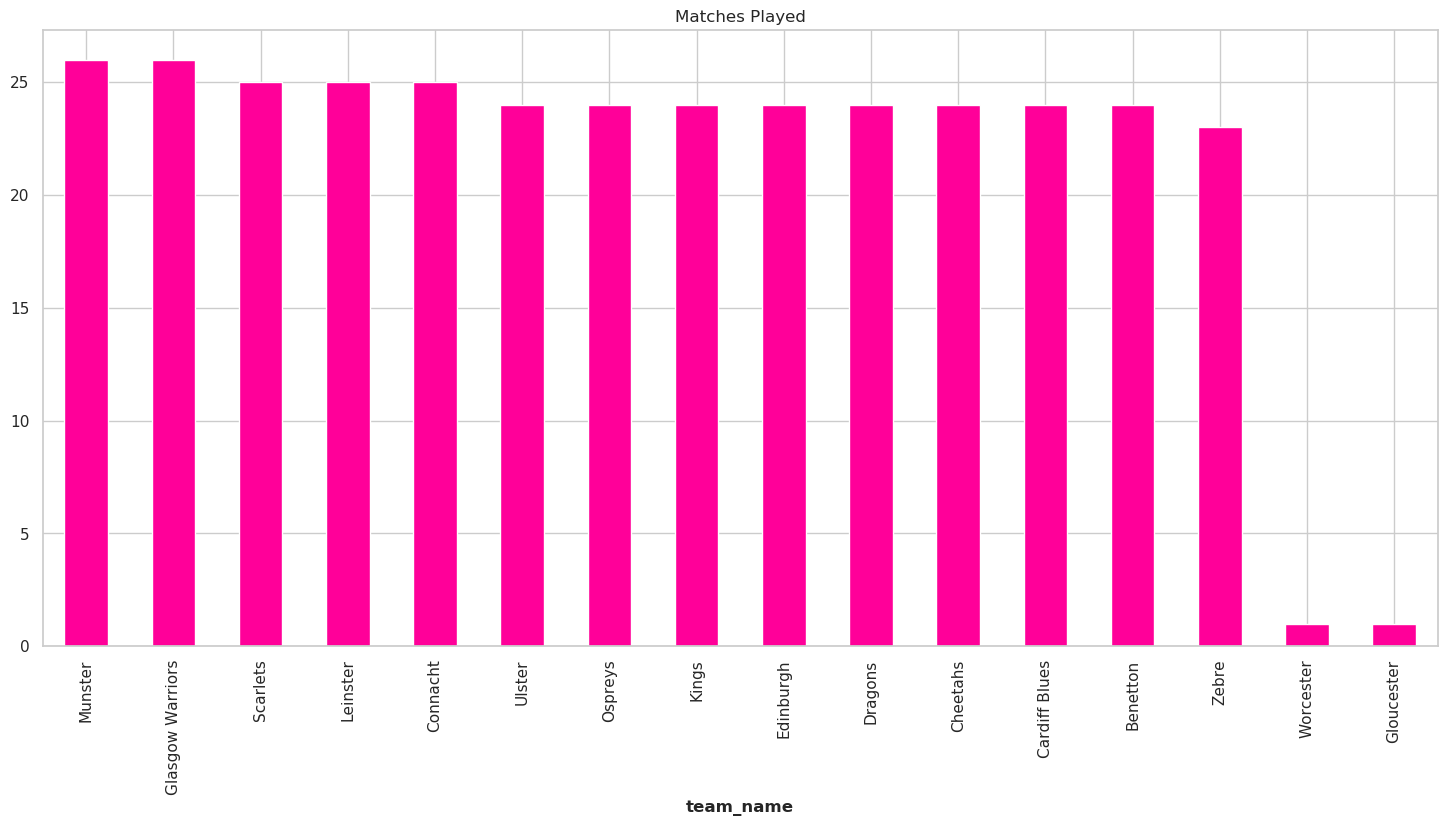

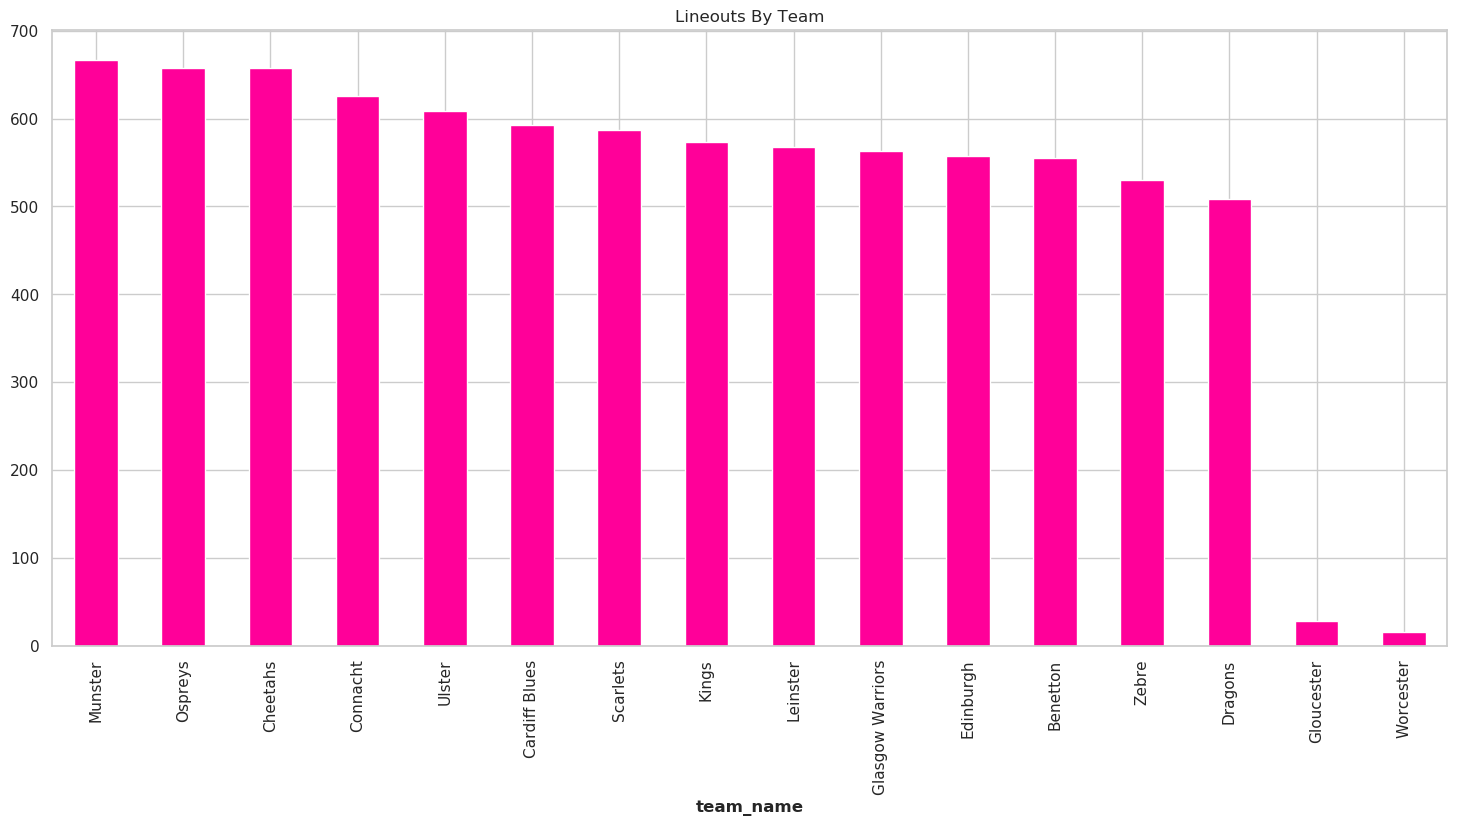

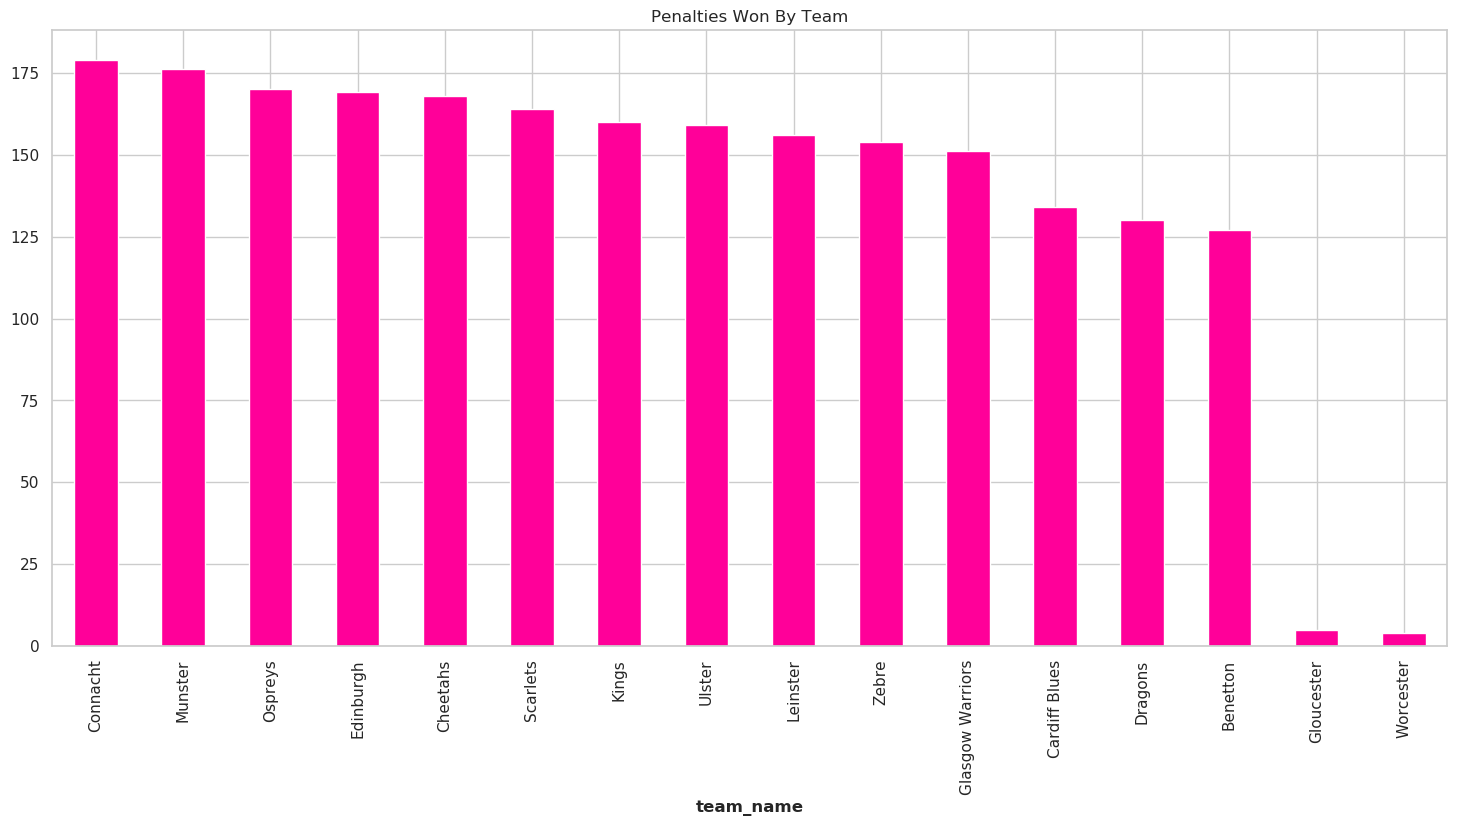

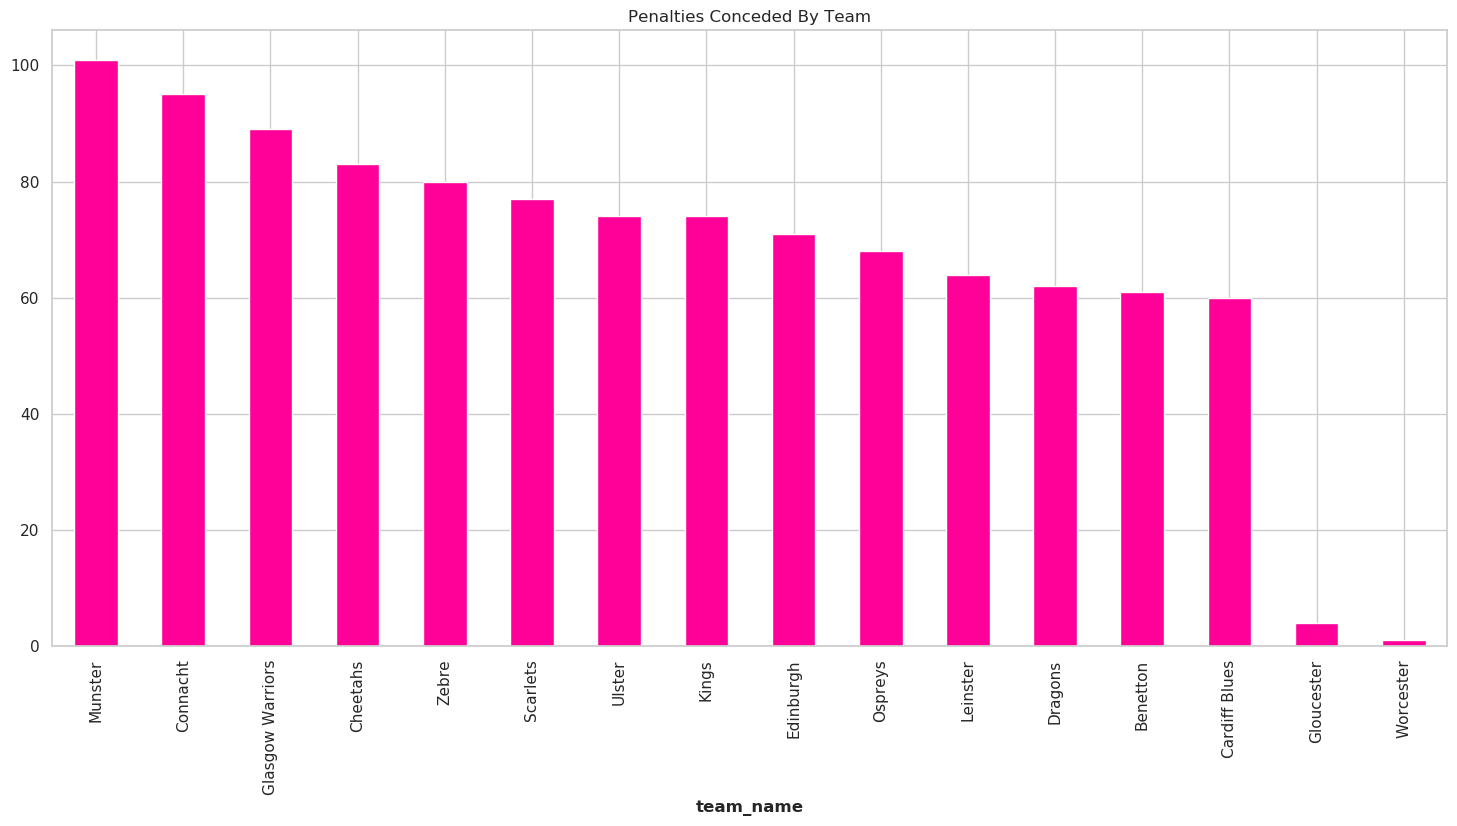

In [47]:
# Matches Played
df.groupby('team_name')['fixture_code'].nunique().sort_values(ascending=False).\
plot.bar(title='Matches Played', figsize=(18,8))
plt.show()

# Lineout by Team
df.groupby('team_name')['lineout'].sum()\
.sort_values(ascending=False).\
plot.bar(title='Lineouts By Team', figsize=(18,8))
plt.show()

# Penalties by Team
df.groupby('team_name')['penalty_won'].sum()\
.sort_values(ascending=False).\
plot.bar(title='Penalties Won By Team', figsize=(18,8))
plt.show()

df.groupby('team_name')['pen_conceded'].sum()\
.sort_values(ascending=False).\
plot.bar(title='Penalties Conceded By Team', figsize=(18,8))
plt.show()

for some reason there was a Gloucester vs. Worcester game in the dataset so lets remove that

In [48]:
df = df.query('team_name != "Worcester"').query('team_name != "Gloucester"')

# The Expected Value of a Lineout

For each zone in the pitch we need to calculate the expected value of a lineout. The average points scored from a period of play that began with a lineout. We need to take into account the following

1. Periods where a team gives away multiple penalties close to the line and the attacking team haver chosen to kick for the courner multiple times. We will count these Lineouts as one,


2. Repeat offending tends to end in yellow cards so we need to know how easier have 14 players on the pitch makes a lineout. 


Trys from Lineouts 13.47% 


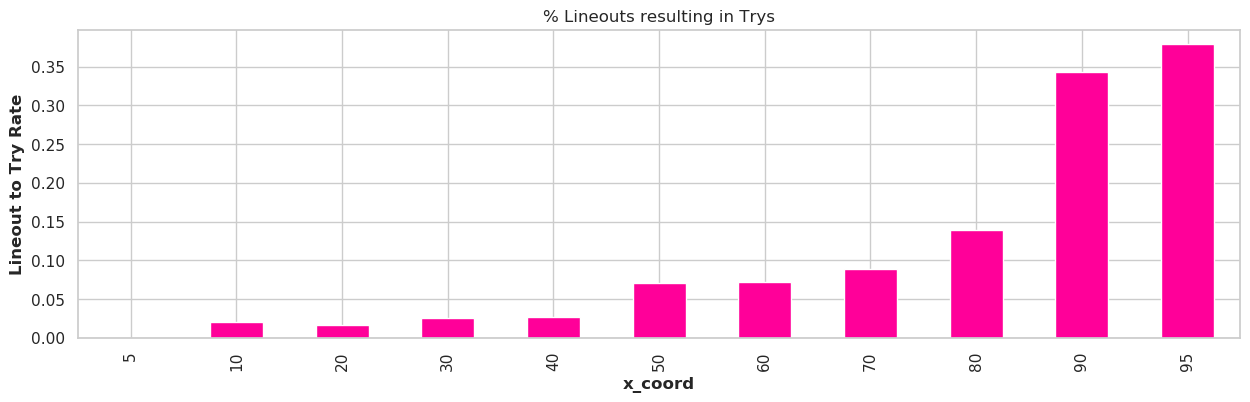

Pentaly or Dropkick from Lineouts 4.58% 


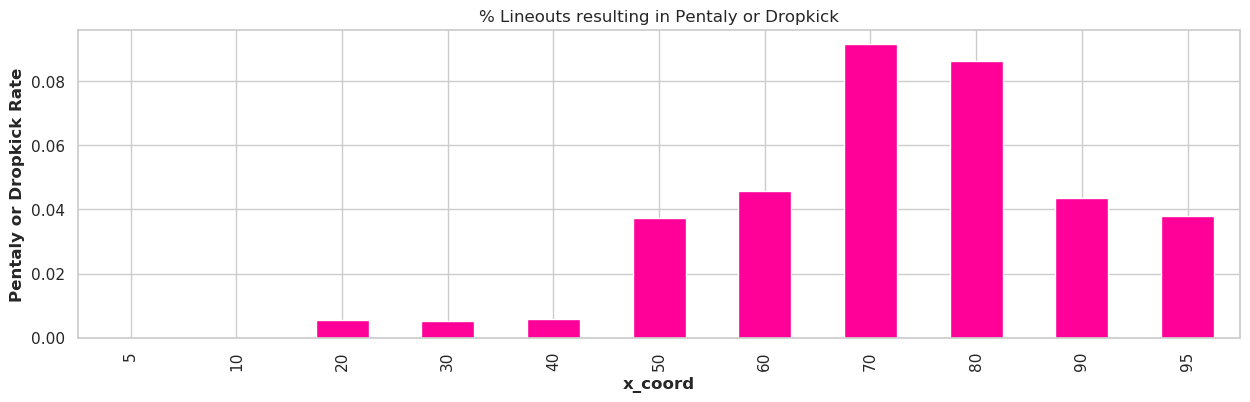

Points from a Lineout 18.05% 


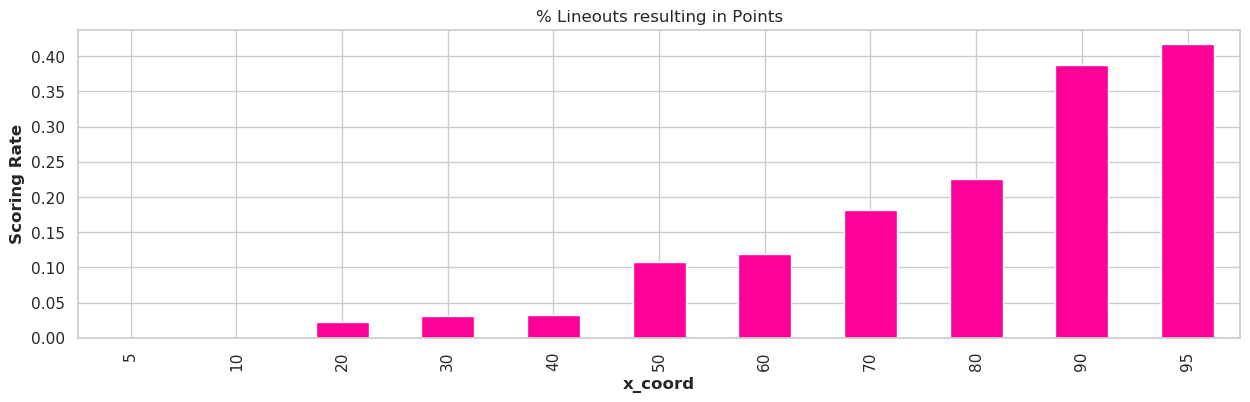

In [49]:
# select lineouts 
lineouts = df.query("start_event == 'Lineout' and x_coord > 0 and x_coord < 100")
lineouts_with_try = df.query("start_event == 'Lineout' and points >= 5 ")
lineouts_with_pen = df.query("start_event == 'Lineout' and points == 3")

lineout_to_try_rate = ((lineouts_with_try.groupby('x_coord')['team_name'].count())/\
 (lineouts.groupby('x_coord')['team_name'].count())).fillna(0)

lineout_to_try_rate.plot.bar(title='% Lineouts resulting in Trys',figsize=(15,4))
plt.ylabel('Lineout to Try Rate')

print('Trys from Lineouts %2.2f%% ' % (len(lineouts_with_try)/len(lineouts)*100) )

plt.show()

lineout_to_pen_rate = ((lineouts_with_pen.groupby('x_coord')['team_name'].count())/\
 (lineouts.groupby('x_coord')['team_name'].count())).fillna(0)

lineout_to_pen_rate.plot.bar(title='% Lineouts resulting in Pentaly or Dropkick',figsize=(15,4))
plt.ylabel('Pentaly or Dropkick Rate')

print('Pentaly or Dropkick from Lineouts %2.2f%% ' % (len(lineouts_with_pen)/len(lineouts)*100) )

plt.show()

lineout_to_points_rate = ((lineouts_with_pen.groupby('x_coord')['team_name'].count() + lineouts_with_try.groupby('x_coord')['team_name'].count())/\
 (lineouts.groupby('x_coord')['team_name'].count())).fillna(0)

lineout_to_points_rate.plot.bar(title='% Lineouts resulting in Points',figsize=(15,4))
plt.ylabel('Scoring Rate')

print('Points from a Lineout %2.2f%% ' % ((len(lineouts_with_try) + len(lineouts_with_pen) ) /len(lineouts)*100) )

plt.show()


Just under 1 in 5 lineouts results in points with the rate increasing the closer to the try line a lineout gets but  as lot of driving mauls off the back of lineouts close to the try line result further penalties which in turn can result in further lineouts we should take that into account to. 

E [Lineout] 2.67 


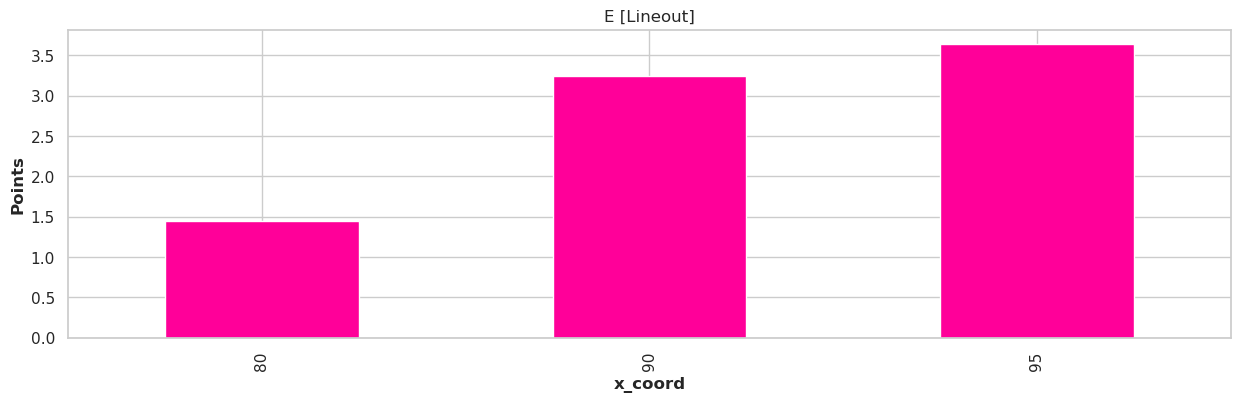

In [50]:
# select lineouts 
lineouts = df.query("start_event == 'Lineout' and end_event != 'End Pen Won' and (x_coord_end > 70 and x_coord > 70)")
lineouts_with_points = df.query("start_event == 'Lineout' and points >= 5 and (x_coord_end > 70 and x_coord > 70) ")

lineout_expected_value_2 = ((lineouts_with_points.groupby('x_coord')['points'].sum())/\
 (lineouts.groupby('x_coord')['team_name'].count())).fillna(0)

lineout_expected_value_2.plot.bar(title='E [Lineout]',figsize=(15,4))
plt.ylabel('Points')

print('E [Lineout] %2.2f ' % ((lineouts_with_points.groupby('x_coord')['points'].sum().sum())/len(lineouts)) )

plt.show()

Text(0, 0.5, 'Expected Value')

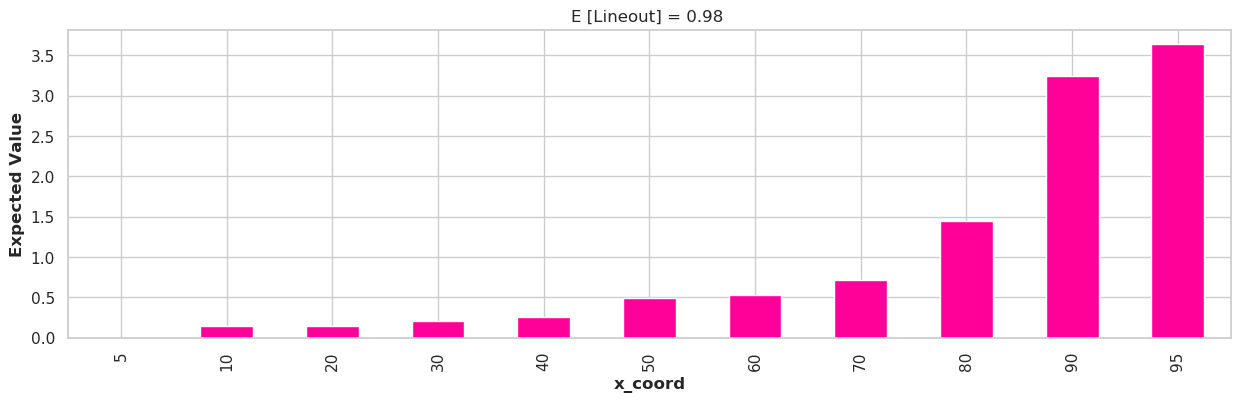

In [70]:
lineout_expected_value = lineout_expected_value.loc[:70].append(lineout_expected_value_2)

lineout_expected_value.plot.bar(title='E [Lineout] = %2.2f ' % ((lineout_expected_value.mean())),figsize=(15,4))
plt.ylabel('Expected Value')

Finally taking cards into account

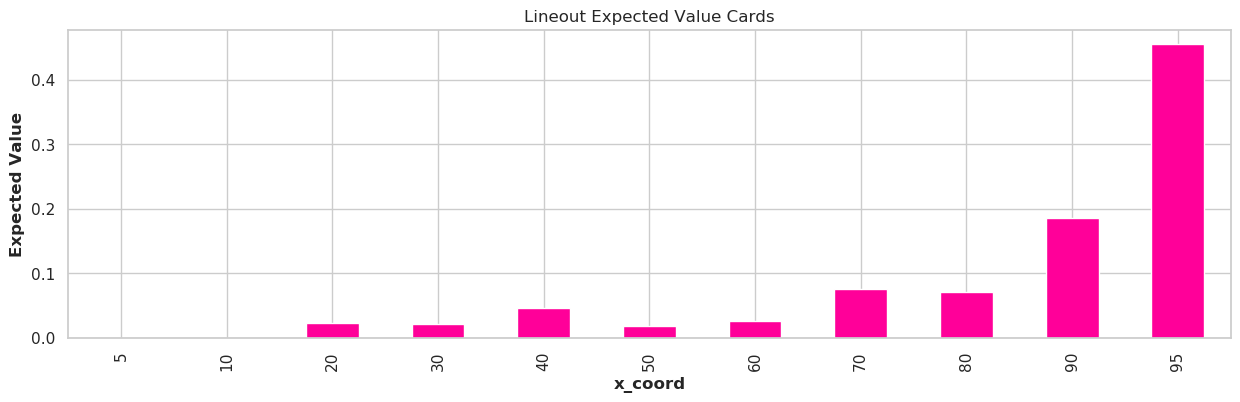

In [53]:
# select lineouts 
lineouts = df.query("start_event == 'Lineout' ")
lineouts_with_cards = df.query("start_event == 'Lineout' and yellow_card >= 1 ")

lineout_with_cards = ((lineouts_with_cards.groupby('x_coord')['team_name'].count()*4.0)/\
 (lineouts.groupby('x_coord')['team_name'].count())).fillna(0)

lineout_with_cards.plot.bar(title='Lineout Expected Value Cards',figsize=(15,4))
plt.ylabel('Expected Value')

plt.show()

And finally our expected value of Try from a Lineout is

Text(0, 0.5, 'Expected Value')

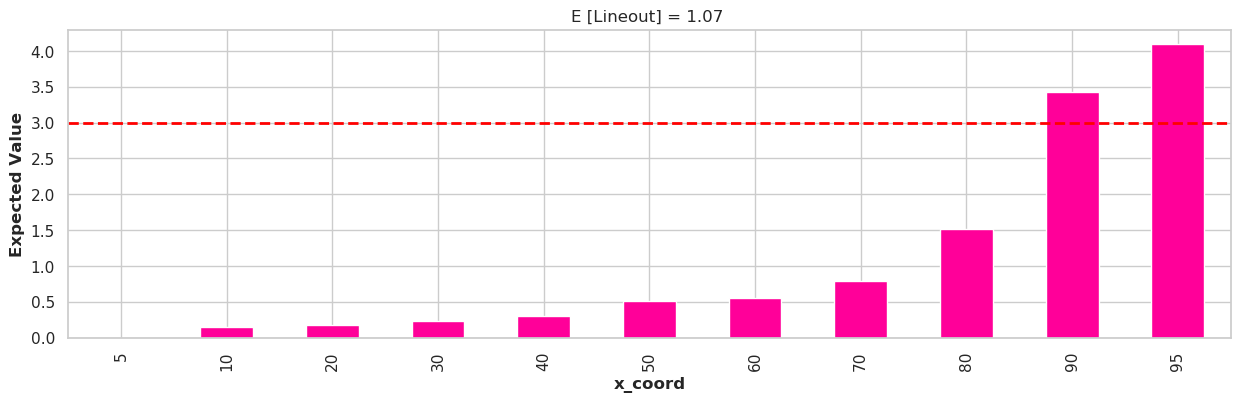

In [71]:
lineout_expected_value = lineout_expected_value + lineout_with_cards
ax = lineout_expected_value.plot.bar(title='E [Lineout] = %2.2f ' % ((lineout_expected_value.mean())),figsize=(15,4))
ax.axhline(y=3, xmin=0, xmax=90, color='r', linestyle='--', lw=2)
plt.ylabel('Expected Value')

In [56]:
lineout_expected_value

x_coord
5     0.000000
10    0.146853
20    0.150000
30    0.213542
40    0.259475
50    0.490654
60    0.526814
70    0.717256
80    1.519769
90    3.427056
95    4.090909
dtype: float64

The expected value of a line out is 1.07 points on average but interesting its higher than 3 points from 10 out so if you can kick a ball from a penalty to with in 10 from the try line you will be better off going for the corner. 

So how hard is that to do? 

# Kick to Touch

Given a team does not take Lineout inline with where they recieved a penalty we need to calculate the expected  distance a team will kick the ball down field to setup the lineout.  

In [58]:
pen_kicks_touch = pd.DataFrame()

for match in matches:
    kicks = match.events.query("event == 'Kick' and description == 'Penalty Kick' and event_type == 'Touch Kick' ")
    
    pen_kicks_touch = pd.concat([pen_kicks_touch,kicks], sort=False)
    
    pen_kicks_touch['x_coord'] = (pen_kicks_touch['x_coord']*1.0).apply(match._Zones)
    pen_kicks_touch['y_coord'] = (pen_kicks_touch['y_coord']*1.0).apply(match._Zones)
    
    pen_kicks_touch['x_coord_end'] = (pen_kicks_touch['x_coord_end']*1.0).apply(match._Zones)
    pen_kicks_touch['y_coord_end'] = (pen_kicks_touch['y_coord_end']*1.0).apply(match._Zones)

In [59]:
pen_kicks_touch['metres'] = pen_kicks_touch['x_coord_end'] - pen_kicks_touch['x_coord']
pen_kicks_touch = pen_kicks_touch.groupby(['x_coord','y_coord'])[['metres']].mean().reset_index()
pen_kicks_touch = pen_kicks_touch.pivot(index='y_coord',columns='x_coord').fillna(0)

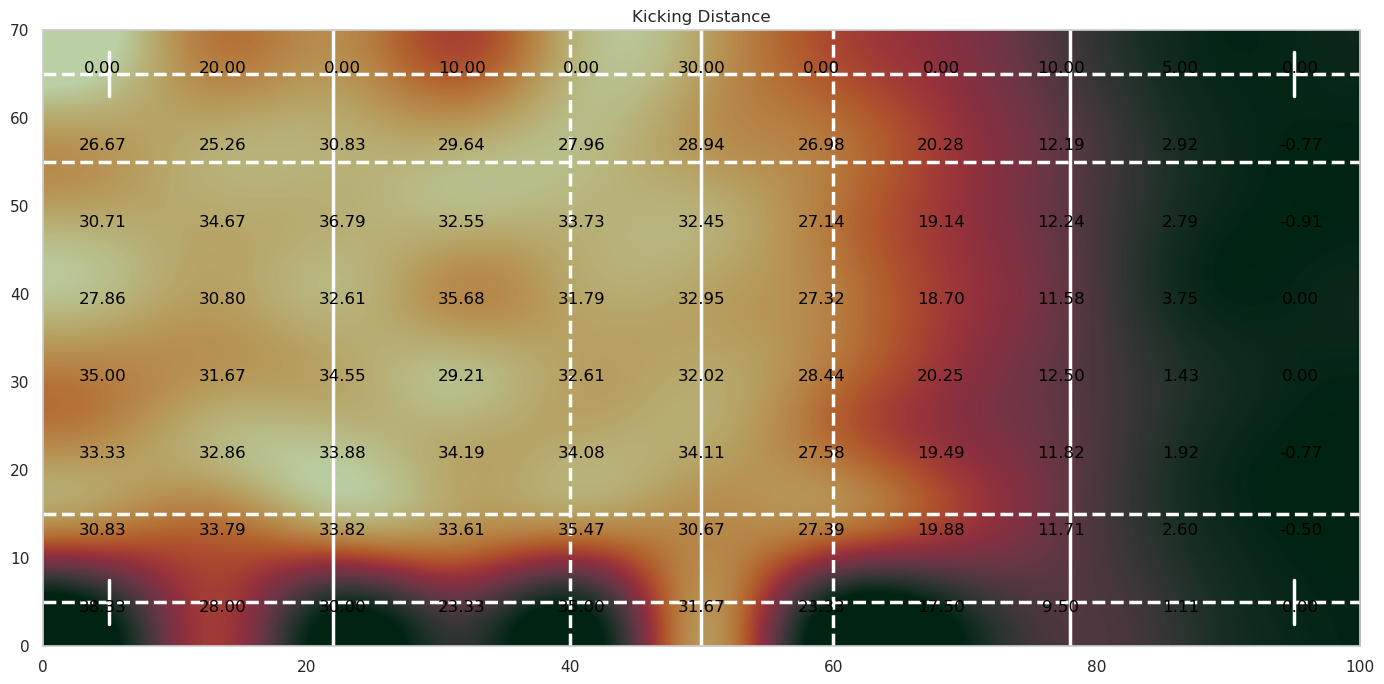

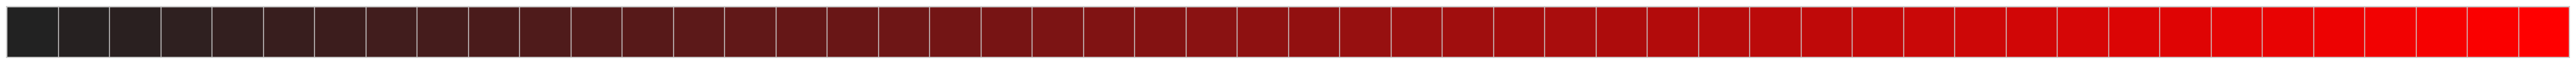

In [60]:
heatmap(pen_kicks_touch,title='Kicking Distance')

So rough 30 to 35 gain seems best the average kicker can achieve

# The Expected Value of a Goal Kick

As a team can choice to kick for goal or not when awarded a penatly measure success rate of penalty kicks can be misleading with teams avoiding hard kicks. A similar problem exists for with a team able to choose the distance from which to take a conversions providing a mislead measure acuracy vs. power. 

In [72]:
pen = len(df.query("end_event == 'End Pen Won' and goal_kick > 0"))
pen_kicked = len(df.query("end_event == 'End Pen Won' and goal_success > 0"))

print('Penalty\'s Kicked %2.2f%% ' % (pen_kicked/pen*100) )

Penalty's Kicked 80.90% 


In [73]:
trys = len(df.query("end_event == 'End Try' "))
conversions = len(df.query("end_event == 'End Try' and goal_success > 0"))

kicking_rate = conversions/trys

print('Conversions %2.2f%% ' % (kicking_rate*100) )

Conversions 73.90% 


We require is a combinded measure that uses conversion for accuracy and pentalty goals for power. This is achived via the formula 

\begin{equation*}
Pr(Goal \space Kick|(x,y)) = Pr(Conversion|(x,y))*Pr(Penatly \space Kick|(x,y))
\end{equation*}

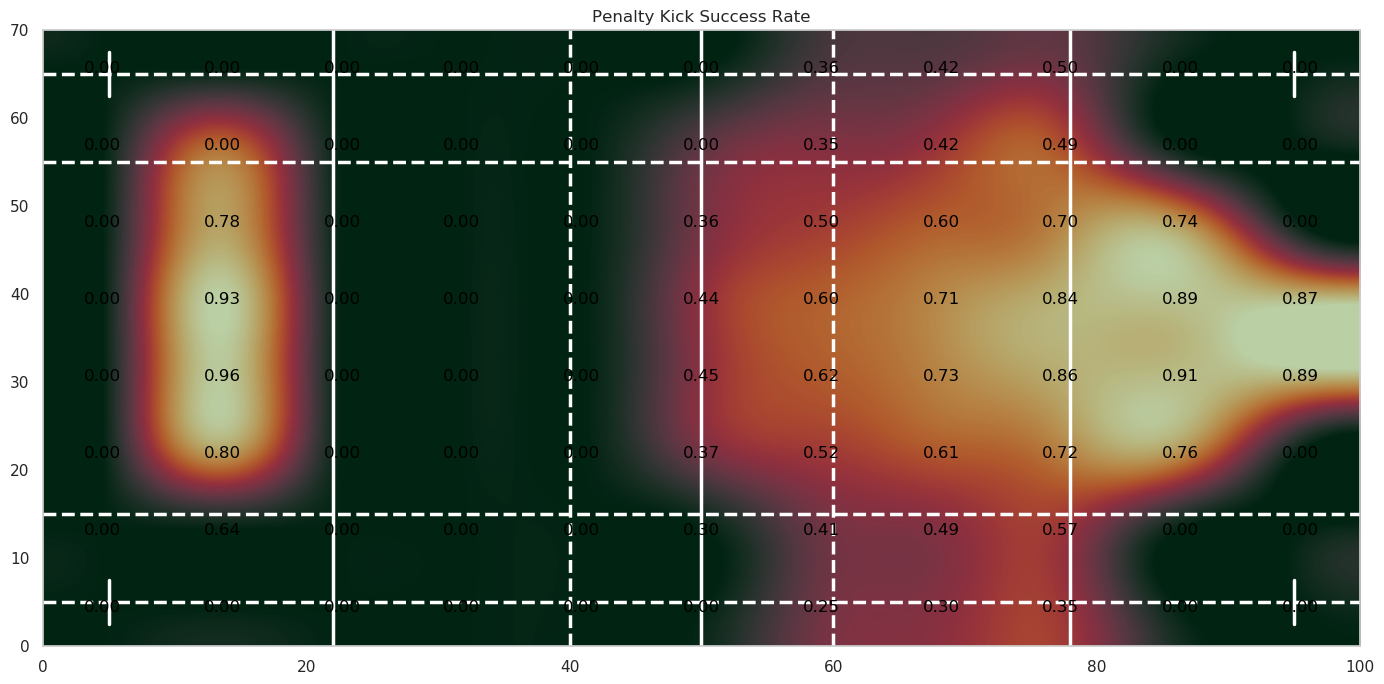

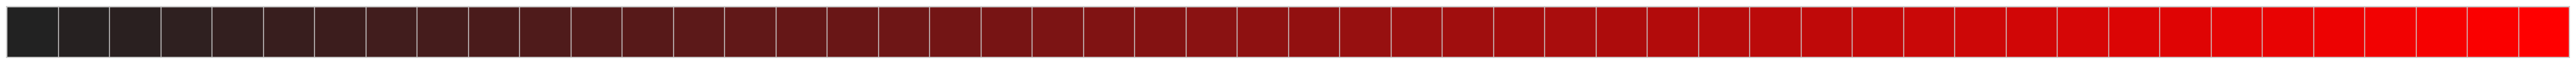

In [74]:
goal_kick_pr = kicking_success(df)
heatmap(goal_kick_pr,title='Penalty Kick Success Rate')

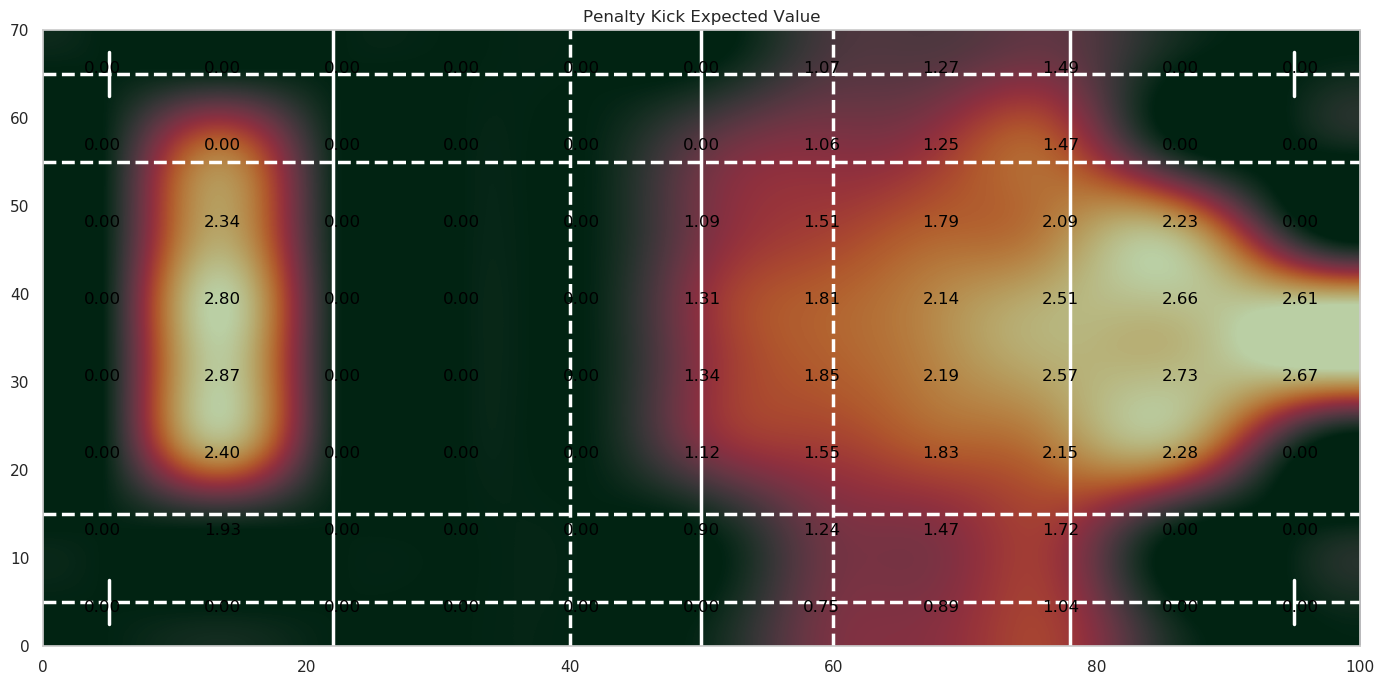

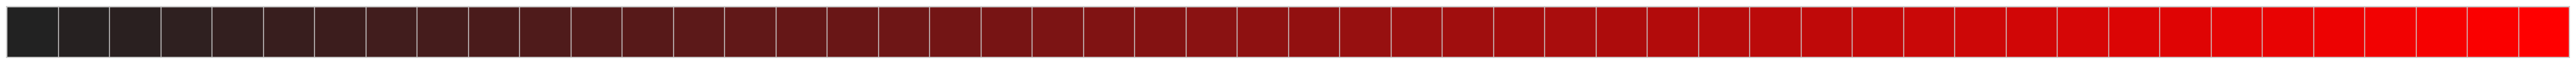

In [75]:
goal_kick_expected_value = kicking_success(df,points=3)
heatmap(goal_kick_expected_value,title='Penalty Kick Expected Value')

I am assuming the kicks from over 90m out are an error in the data. 

# Putting It Together

Finally we can put it all together to calulate with the probality of scoring points is higher when kicking to touch and the expected value. 

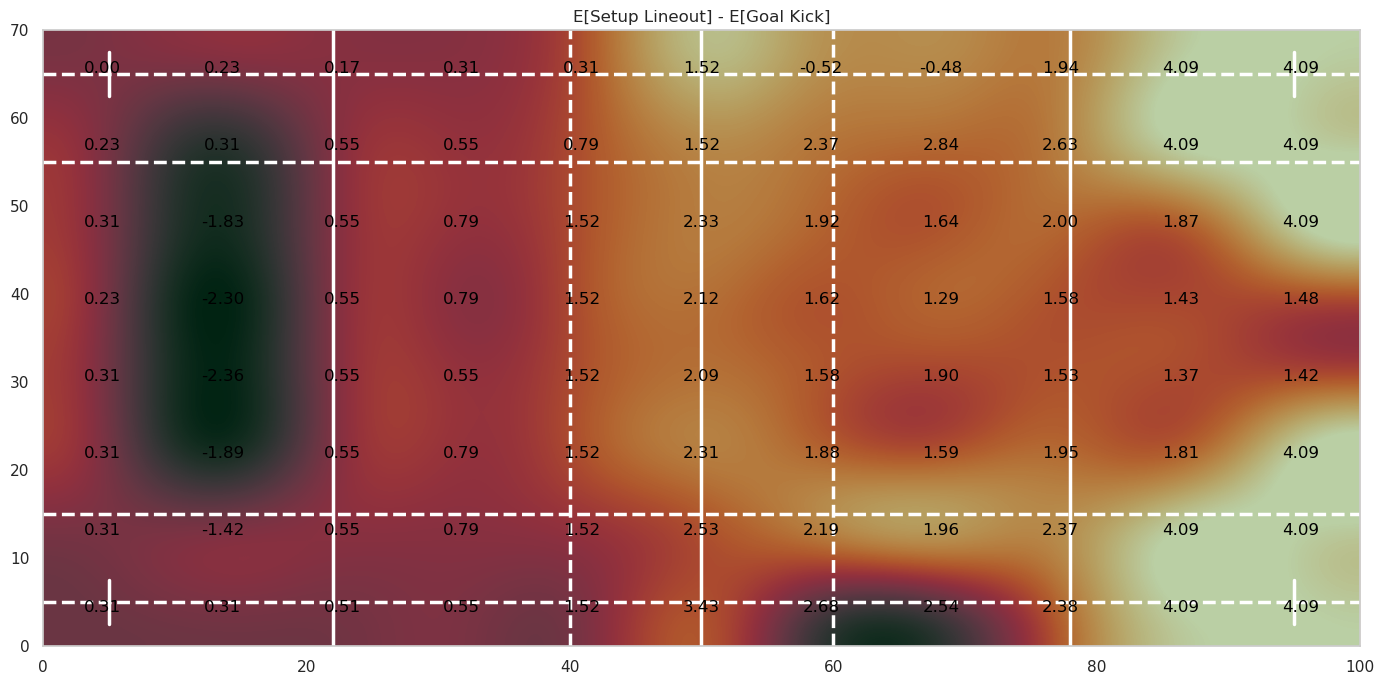

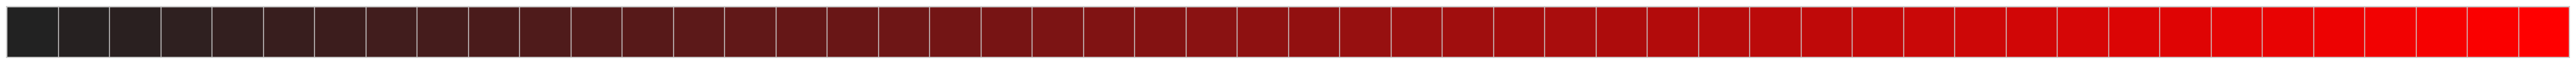

In [79]:
#expected value
pen_kicks_touch_steps = pen_kicks_touch/10
pen_kicks_touch_steps = pen_kicks_touch_steps.apply(np.ceil)
rows = []
for x in range(0,len(pen_kicks_touch_steps.columns)):
    row = []
    for y in range(0,len(pen_kicks_touch_steps)):
        row.append(lineout_expected_value.values[int(x + pen_kicks_touch_steps.values[y,x])] - goal_kick_expected_value.iloc[y,x])
        
    rows.append(row)

line_vs_kick_expected_value = pd.DataFrame(rows).T
line_vs_kick_expected_value.columns = pen_kicks_touch_steps.columns
line_vs_kick_expected_value.index = pen_kicks_touch_steps.index

heatmap(line_vs_kick_expected_value,title="E[Setup Lineout] - E[Goal Kick]")

## Scrums  

Finally we need to look at scrums as with lineouts we need to take into account repeated penalties and cards  

Trys from Scrums 11.26% 


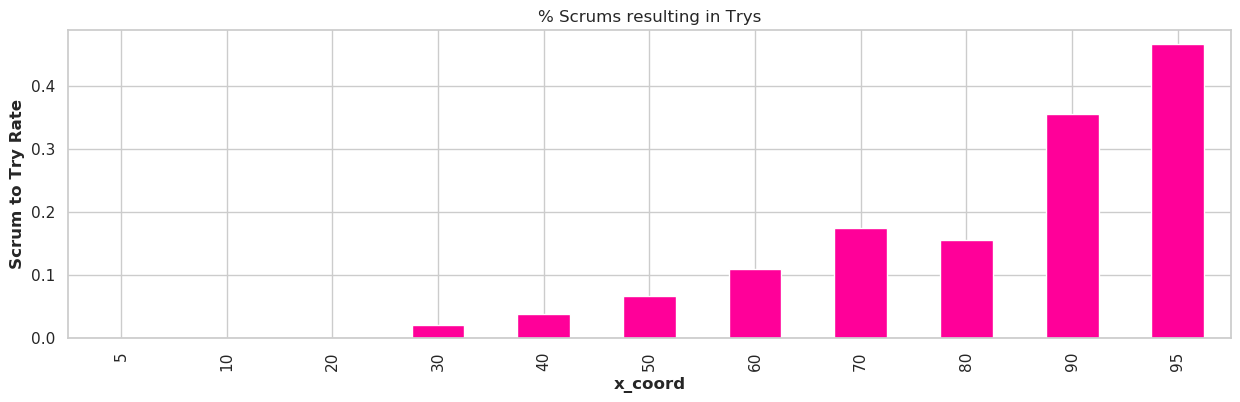

Pentaly or Dropkick from Scrums 3.69% 


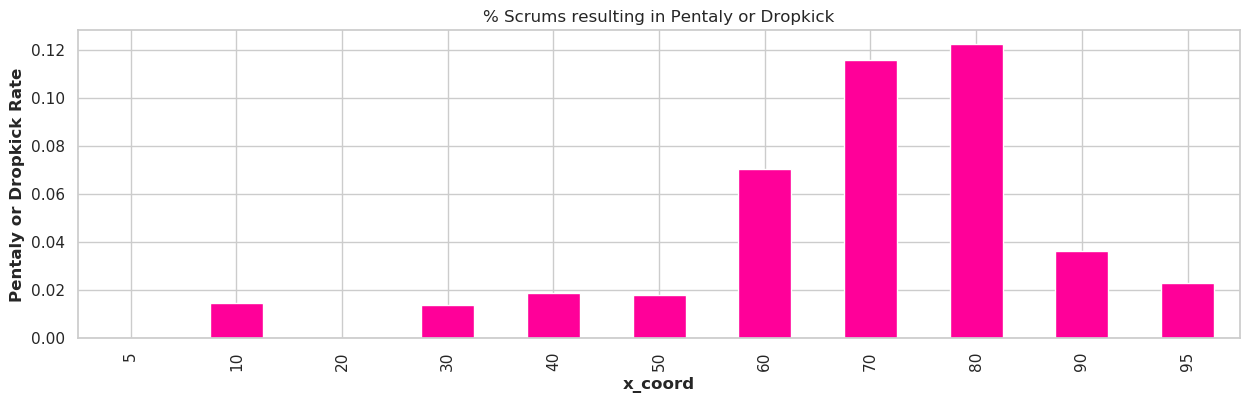

In [95]:
scrums_df = df.query("start_event == 'Scrum' and x_coord > 0 and x_coord < 100")
scrums_with_try = scrums_df.query("start_event == 'Scrum' and points >= 5 ")
scrums_with_pen = scrums_df.query("start_event == 'Scrum' and points == 3")

scrum_to_try_rate = ((scrums_with_try.groupby('x_coord')['team_name'].count())/\
 (scrums_df.groupby('x_coord')['team_name'].count())).fillna(0)

scrum_to_try_rate.plot.bar(title='% Scrums resulting in Trys',figsize=(15,4))
plt.ylabel('Scrum to Try Rate')

print('Trys from Scrums %2.2f%% ' % (len(scrums_with_try)/len(scrums_df)*100) )

plt.show()

scrum_to_pen_rate = ((scrums_with_pen.groupby('x_coord')['team_name'].count())/\
 (scrums_df.groupby('x_coord')['team_name'].count())).fillna(0)

scrum_to_pen_rate.plot.bar(title='% Scrums resulting in Pentaly or Dropkick',figsize=(15,4))
plt.ylabel('Pentaly or Dropkick Rate')

print('Pentaly or Dropkick from Scrums %2.2f%% ' % (len(scrums_with_pen)/len(scrums_df)*100) )

plt.show()


In [85]:
scrum_value

,x_coord,y_coord,points
0,5,5,0.000000
1,5,10,0.000000
2,5,20,0.000000
3,5,30,0.000000
4,5,40,0.000000
...,...,...,...
75,95,20,2.529412
76,95,30,2.625000
77,95,40,3.925926
78,95,50,3.818182


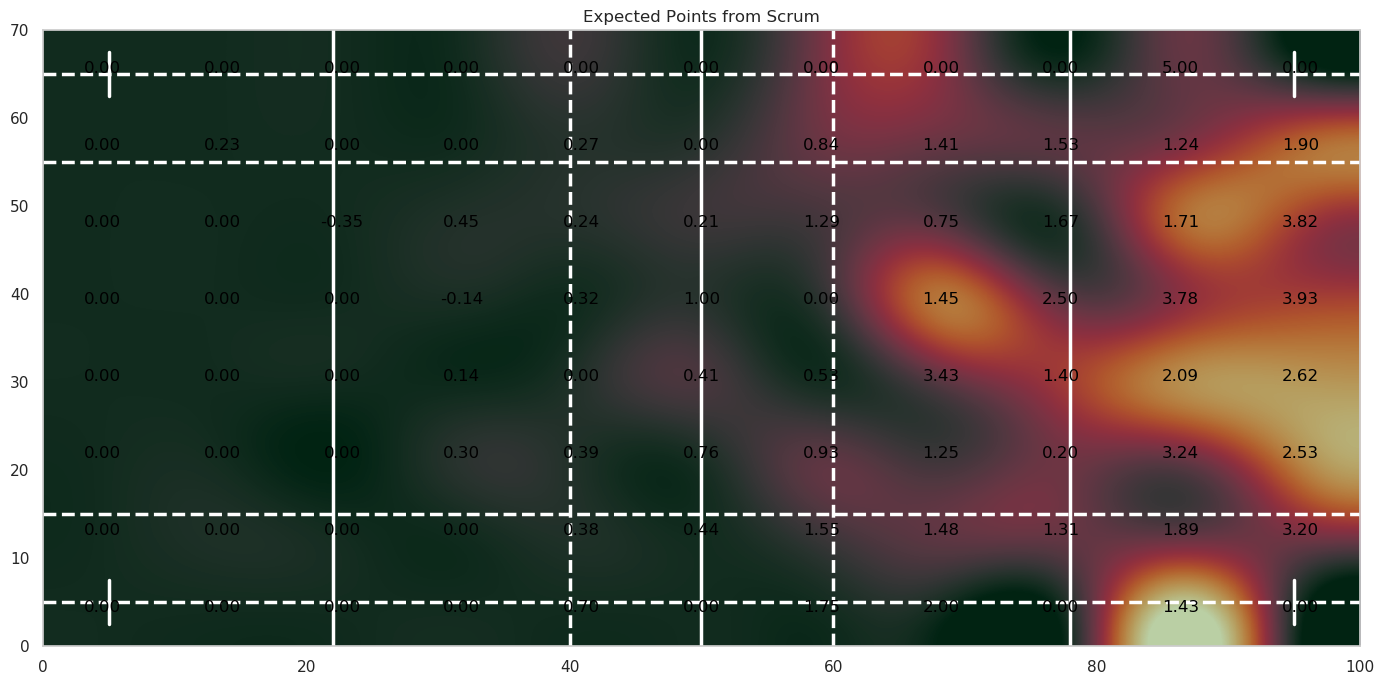

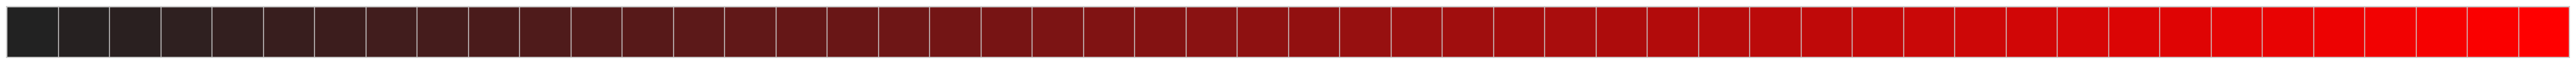

In [92]:
scrum_value = pd.pivot_table(scrums_df,index='y_coord',columns='x_coord',values='points').fillna(0)
heatmap(scrum_value,title='Expected Points from Scrum')

Scrums are less clear it seems that if you are with in 10 and center field they are woth more than a kick for goal but are less than four points (just) than a lineout. 

## Quick Tap

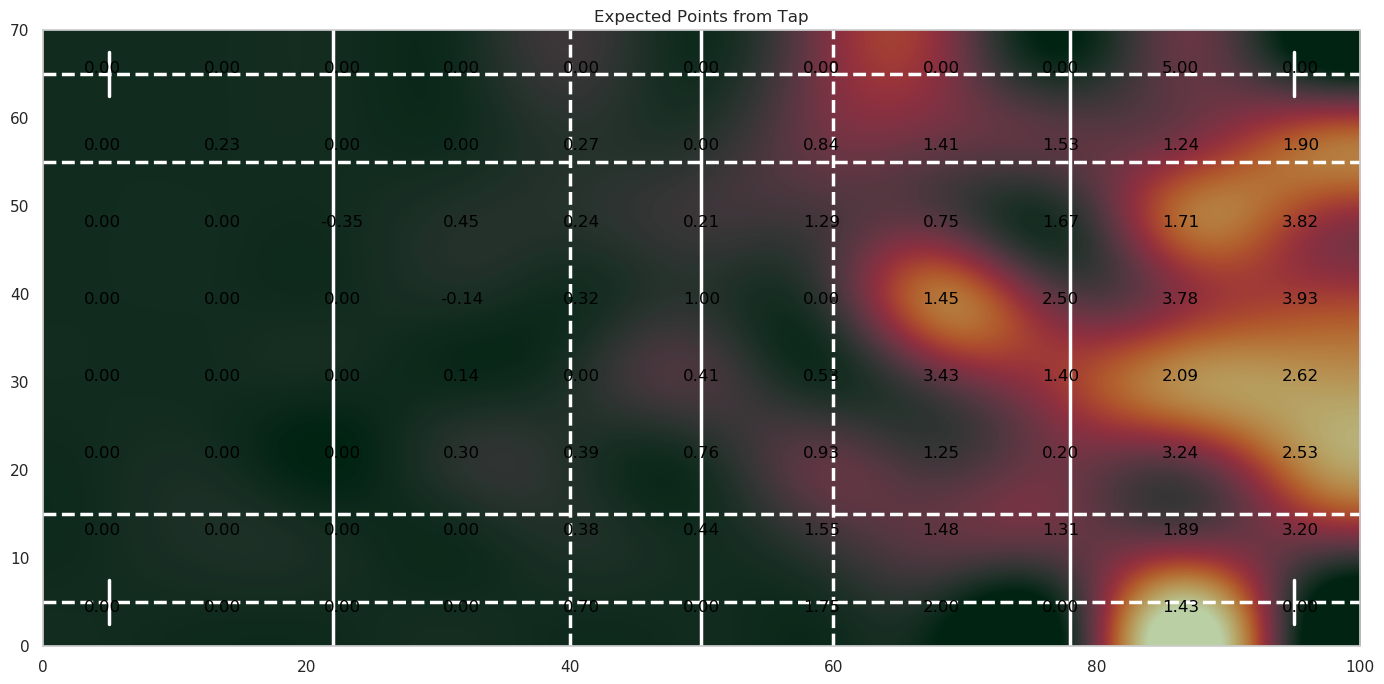

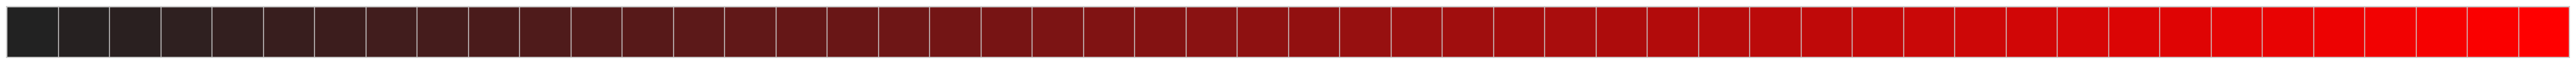

In [101]:
taps_df = df.query("tap_pen > 0")
taps_df = pd.pivot_table(taps_df,index='y_coord',columns='x_coord',values='points').fillna(0)
heatmap(scrum_value,title='Expected Points from Tap')

In [107]:
df.query("tap_pen > 0").groupby('team_name')['fixture_code'].count().sort_values()

team_name
Ulster              25
Zebre               32
Leinster            34
Cheetahs            36
Kings               37
Connacht            41
Scarlets            42
Benetton            46
Edinburgh           49
Glasgow Warriors    55
Dragons             57
Cardiff Blues       59
Ospreys             60
Munster             67
Name: fixture_code, dtype: int64

You are never better off taking a tap penalty 